In [43]:
# Cell 0 - Config / Environment
import os
from pathlib import Path
import random
import warnings
warnings.filterwarnings("ignore")
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Save directory (user requested)
RESULT_DIR = Path("/Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/ml")
RESULT_DIR.mkdir(parents=True, exist_ok=True)

# Data path - change if needed
DATA_PATH = Path("/Users/ravigurjar/Desktop/temp/sample/dessertation/data/cleaned/final_df.csv")   # <-- replace with your CSV

In [44]:
# Cell 1 - Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [45]:
# Cell 2 - Load data (attempt to parse datetime index)
if not DATA_PATH.exists():
    raise FileNotFoundError(f"{DATA_PATH} not found. Put your CSV there or update DATA_PATH.")

df = pd.read_csv(DATA_PATH)
# If 'date' column exists, convert to datetime and set as index
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date').sort_index()

# If index is not datetime, try convert
if not np.issubdtype(df.index.dtype, np.datetime64):
    try:
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
    except Exception:
        print("Warning: index is not datetime. Proceeding but time features may be limited.")

# show head and numeric columns
print("Shape:", df.shape)
print(df.head())
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) == 0:
    raise ValueError("No numeric columns found. Ensure AQI column is numeric.")
TARGET = numeric_cols[0]
print("Using numeric target column:", TARGET)

Shape: (7835, 13)
                                         timestamp   latitude  longitude  \
1970-01-01 00:00:00.000000000  2024-05-01 09:00:00  14.675886  77.593027   
1970-01-01 00:00:00.000000001  2024-05-01 05:00:00  16.987287  81.736318   
1970-01-01 00:00:00.000000002  2024-05-01 10:00:00  13.670000  79.350000   
1970-01-01 00:00:00.000000003  2020-11-19 16:00:00  16.507014  80.627767   
1970-01-01 00:00:00.000000004  2024-05-01 10:00:00  27.103358  93.679645   

                               pm25_ugm3  co_ppm  no2_ppb  so2_ppb  o3_ppb  \
1970-01-01 00:00:00.000000000       75.0     7.2      4.7      3.6     6.8   
1970-01-01 00:00:00.000000001        5.0     5.8      1.1      4.7     6.5   
1970-01-01 00:00:00.000000002       90.0     7.3     10.0      4.1    12.5   
1970-01-01 00:00:00.000000003       52.0     4.2      0.7      4.9     5.1   
1970-01-01 00:00:00.000000004      127.0     2.8      1.1      1.7     1.0   

                               temperature_c  relative_h

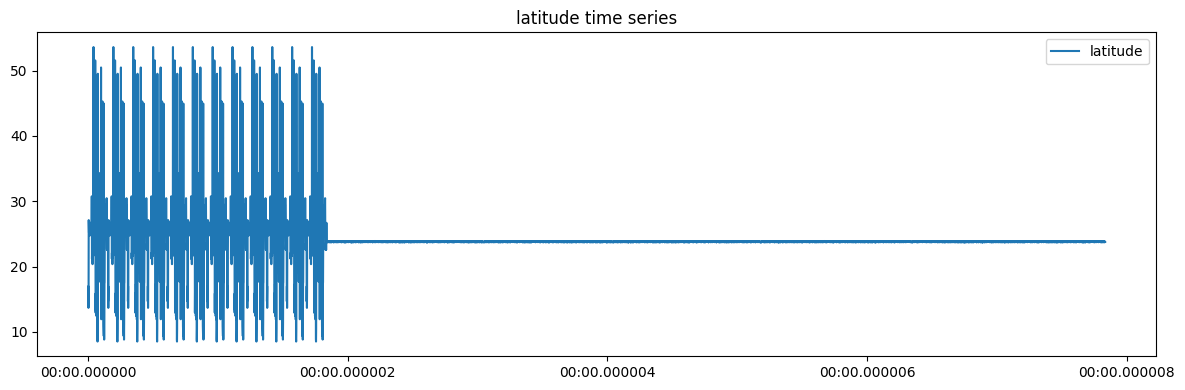

In [46]:
# Cell 3 - Quick plot of target
plt.figure(figsize=(12,4))
plt.plot(df.index, df[TARGET], label=TARGET)
plt.title(f"{TARGET} time series")
plt.legend(); plt.tight_layout(); plt.show()

In [47]:
# Cell 4 - Preprocessing: fill missing target values
df[TARGET] = df[TARGET].ffill().bfill()

In [48]:
# Cell 5 - Feature engineering: lag + rolling features generator (no leakage)
def make_supervised(series: pd.Series, lags=(1,2,3,7,14), rolling_windows=(3,7,14), horizon=0):
    """
    Create X,y where y = series.shift(-horizon) (horizon=0 => y_t, horizon=1 => y_{t+1})
    Features are computed using past values only (shifted appropriately to avoid leakage).
    """
    s = series.copy()
    dfX = pd.DataFrame(index=s.index)
    # create lag features: lag_k = y_{t-k}
    for lag in lags:
        dfX[f'lag_{lag}'] = s.shift(lag)
    # rolling features computed up to t-1 (shift by 1 before rolling) to avoid using current time
    for w in rolling_windows:
        dfX[f'roll_mean_{w}'] = s.shift(1).rolling(window=w).mean()
        dfX[f'roll_std_{w}'] = s.shift(1).rolling(window=w).std()
    # time features (if datetime index)
    if np.issubdtype(s.index.dtype, np.datetime64):
        dfX['dow'] = s.index.dayofweek
        dfX['month'] = s.index.month
    # target: shift negative horizon (future). For horizon=0, target is current value y_t.
    y = s.shift(-horizon)
    # combine and drop rows with NaNs (created by shifting/rolling or final rows when horizon>0)
    df_all = dfX.copy()
    df_all['y'] = y
    df_all = df_all.dropna().copy()
    return df_all

# Example inspect
h0 = make_supervised(df[TARGET], lags=(1,2,3,7), rolling_windows=(3,7), horizon=0)
h1 = make_supervised(df[TARGET], lags=(1,2,3,7), rolling_windows=(3,7), horizon=1)
print("Stage1 sample shape (horizon=0):", h0.shape)
print("Stage2 sample shape (horizon=1):", h1.shape)
h0.head()

Stage1 sample shape (horizon=0): (7828, 11)
Stage2 sample shape (horizon=1): (7827, 11)


,lag_1,lag_2,lag_3,lag_7,roll_mean_3,roll_std_3,roll_mean_7,roll_std_7,dow,month,y
1970-01-01 00:00:00.000000007,25.204762,26.187500,27.103358,14.675886,26.165207,0.949494,20.047972,5.852475,3,1,25.562610
1970-01-01 00:00:00.000000008,25.562610,25.204762,26.187500,16.987287,25.651624,0.497379,21.603219,5.629227,3,1,25.444266
1970-01-01 00:00:00.000000009,25.444266,25.562610,25.204762,13.670000,25.403879,0.182310,22.811359,5.375233,3,1,26.803650
1970-01-01 00:00:00.000000010,26.803650,25.444266,25.562610,16.507014,25.936842,0.753006,24.687594,3.676295,3,1,25.251013
1970-01-01 00:00:00.000000011,25.251013,26.803650,25.444266,27.103358,25.832976,0.846163,25.936737,0.770706,3,1,25.204762


In [49]:
# Cell 6 - Build datasets for Stage 1 and Stage 2
LAGS = (1,2,3,7,14,21)
ROLLS = (3,7,14)

# Stage 1: AQI(t) -> horizon = 0 (nowcast)
data_stage1 = make_supervised(df[TARGET], lags=LAGS, rolling_windows=ROLLS, horizon=0)

# Stage 2: AQI(t+1) -> horizon = 1 (one-step ahead)
data_stage2 = make_supervised(df[TARGET], lags=LAGS, rolling_windows=ROLLS, horizon=1)

print("Stage1 rows:", len(data_stage1), "Stage2 rows:", len(data_stage2))

Stage1 rows: 7814 Stage2 rows: 7813


In [50]:
# Cell 7 - Train/test split function (last 20% as test)
def train_test_split_timeseries(data_df, test_size=0.2):
    n = len(data_df)
    test_n = int(n * test_size)
    train = data_df.iloc[:-test_n]
    test = data_df.iloc[-test_n:]
    X_train = train.drop(columns=['y'])
    y_train = train['y']
    X_test = test.drop(columns=['y'])
    y_test = test['y']
    return X_train, X_test, y_train, y_test

X1_train, X1_test, y1_train, y1_test = train_test_split_timeseries(data_stage1, test_size=0.2)
X2_train, X2_test, y2_train, y2_test = train_test_split_timeseries(data_stage2, test_size=0.2)

print("Stage1 train/test:", X1_train.shape, X1_test.shape)
print("Stage2 train/test:", X2_train.shape, X2_test.shape)

Stage1 train/test: (6252, 14) (1562, 14)
Stage2 train/test: (6251, 14) (1562, 14)


In [51]:
# Cell 8 - Evaluation helper (compatibile with older sklearn)
def evaluate(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

In [52]:
# Cell 9 - Baseline (naive) metrics for both stages
# For naive baseline we use lag_1 as forecast (i.e., y_hat_t = y_{t-1}).
# For horizon=1 this is the standard persistence baseline.
naive1 = X1_test['lag_1'].values
naive2 = X2_test['lag_1'].values
metrics_naive1 = evaluate(y1_test.values, naive1)
metrics_naive2 = evaluate(y2_test.values, naive2)
print("Naive Stage1 metrics:", metrics_naive1)
print("Naive Stage2 metrics:", metrics_naive2)

Naive Stage1 metrics: {'MAE': 0.06644222651728551, 'RMSE': 0.08138905876923205, 'R2': -0.9534126548931714}
Naive Stage2 metrics: {'MAE': 0.06793249229833546, 'RMSE': 0.08294608628668161, 'R2': -1.0288677698673525}


In [53]:
# Cell 10 - Models dictionary (same models for both stages)
models = {
    "LinearRegression": Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
    "Ridge": Pipeline([('scaler', StandardScaler()), ('model', Ridge(random_state=RANDOM_SEED))]),
    "Lasso": Pipeline([('scaler', StandardScaler()), ('model', Lasso(random_state=RANDOM_SEED, max_iter=10000))]),
    "SVR": Pipeline([('scaler', StandardScaler()), ('model', SVR())]),
    "RandomForest": Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(n_estimators=200, random_state=RANDOM_SEED))]),
}
tscv = TimeSeriesSplit(n_splits=5)

In [54]:
# Cell 11 - Train & evaluate for Stage 1
results_stage1 = []
for name, pipeline in models.items():
    print("Stage1 - Training:", name)
    pipeline.fit(X1_train, y1_train)
    y1_pred = pipeline.predict(X1_test)
    m = evaluate(y1_test, y1_pred)
    m['model'] = name
    results_stage1.append(m)
    joblib.dump(pipeline, RESULT_DIR / f"{name}_stage1.joblib")
    print(name, m)

# add naive row
results_stage1_df = pd.DataFrame(results_stage1).set_index('model')
results_stage1_df.loc['Naive'] = pd.Series(metrics_naive1)
results_stage1_df = results_stage1_df[['MAE','RMSE','R2']]
results_stage1_df.to_csv(RESULT_DIR / "metrics_stage1.csv")
print("\nStage1 summary saved to metrics_stage1.csv\n", results_stage1_df)

Stage1 - Training: LinearRegression
LinearRegression {'MAE': 0.16598302438561743, 'RMSE': 0.1770083012738731, 'R2': -8.23951581601677, 'model': 'LinearRegression'}
Stage1 - Training: Ridge
Ridge {'MAE': 0.16601265250557687, 'RMSE': 0.1770353388397081, 'R2': -8.242338656466483, 'model': 'Ridge'}
Stage1 - Training: Lasso
Lasso {'MAE': 0.09627327072890196, 'RMSE': 0.11240216020937333, 'R2': -2.725728984429813, 'model': 'Lasso'}
Stage1 - Training: SVR
SVR {'MAE': 0.052105120250167086, 'RMSE': 0.061375938419219345, 'R2': -0.1108572034086881, 'model': 'SVR'}
Stage1 - Training: RandomForest
RandomForest {'MAE': 0.05081061984623379, 'RMSE': 0.05879414015743136, 'R2': -0.0193657358341095, 'model': 'RandomForest'}

Stage1 summary saved to metrics_stage1.csv
                        MAE      RMSE        R2
model                                         
LinearRegression  0.165983  0.177008 -8.239516
Ridge             0.166013  0.177035 -8.242339
Lasso             0.096273  0.112402 -2.725729
SVR   

In [55]:
# Cell 12 - Train & evaluate for Stage 2
results_stage2 = []
for name, pipeline in models.items():
    print("Stage2 - Training:", name)
    pipeline.fit(X2_train, y2_train)
    y2_pred = pipeline.predict(X2_test)
    m = evaluate(y2_test, y2_pred)
    m['model'] = name
    results_stage2.append(m)
    joblib.dump(pipeline, RESULT_DIR / f"{name}_stage2.joblib")
    print(name, m)

# add naive row
results_stage2_df = pd.DataFrame(results_stage2).set_index('model')
results_stage2_df.loc['Naive'] = pd.Series(metrics_naive2)
results_stage2_df = results_stage2_df[['MAE','RMSE','R2']]
results_stage2_df.to_csv(RESULT_DIR / "metrics_stage2.csv")
print("\nStage2 summary saved to metrics_stage2.csv\n", results_stage2_df)

Stage2 - Training: LinearRegression
LinearRegression {'MAE': 0.14227249509744, 'RMSE': 0.15552340313912857, 'R2': -6.13269159759231, 'model': 'LinearRegression'}
Stage2 - Training: Ridge
Ridge {'MAE': 0.1423012426020584, 'RMSE': 0.1555476282572799, 'R2': -6.134913819464382, 'model': 'Ridge'}
Stage2 - Training: Lasso
Lasso {'MAE': 0.10581978301578426, 'RMSE': 0.12079596729412453, 'R2': -3.3029551205492584, 'model': 'Lasso'}
Stage2 - Training: SVR
SVR {'MAE': 0.05628895315698903, 'RMSE': 0.06757962958775902, 'R2': -0.3467703879859896, 'model': 'SVR'}
Stage2 - Training: RandomForest
RandomForest {'MAE': 0.05043235004210194, 'RMSE': 0.058538041337188144, 'R2': -0.010504655620939385, 'model': 'RandomForest'}

Stage2 summary saved to metrics_stage2.csv
                        MAE      RMSE        R2
model                                         
LinearRegression  0.142272  0.155523 -6.132692
Ridge             0.142301  0.155548 -6.134914
Lasso             0.105820  0.120796 -3.302955
SVR    

In [56]:
# Cell 13 - Save predictions for both stages
preds1 = pd.DataFrame(index=y1_test.index)
preds1['y_true'] = y1_test
for name in models.keys():
    mdl = joblib.load(RESULT_DIR / f"{name}_stage1.joblib")
    preds1[name] = mdl.predict(X1_test)
preds1['Naive'] = X1_test['lag_1'].values
preds1.to_csv(RESULT_DIR / "predictions_stage1.csv")
print("Saved Stage1 predictions to predictions_stage1.csv")

preds2 = pd.DataFrame(index=y2_test.index)
preds2['y_true'] = y2_test
for name in models.keys():
    mdl = joblib.load(RESULT_DIR / f"{name}_stage2.joblib")
    preds2[name] = mdl.predict(X2_test)
preds2['Naive'] = X2_test['lag_1'].values
preds2.to_csv(RESULT_DIR / "predictions_stage2.csv")
print("Saved Stage2 predictions to predictions_stage2.csv")

Saved Stage1 predictions to predictions_stage1.csv
Saved Stage2 predictions to predictions_stage2.csv


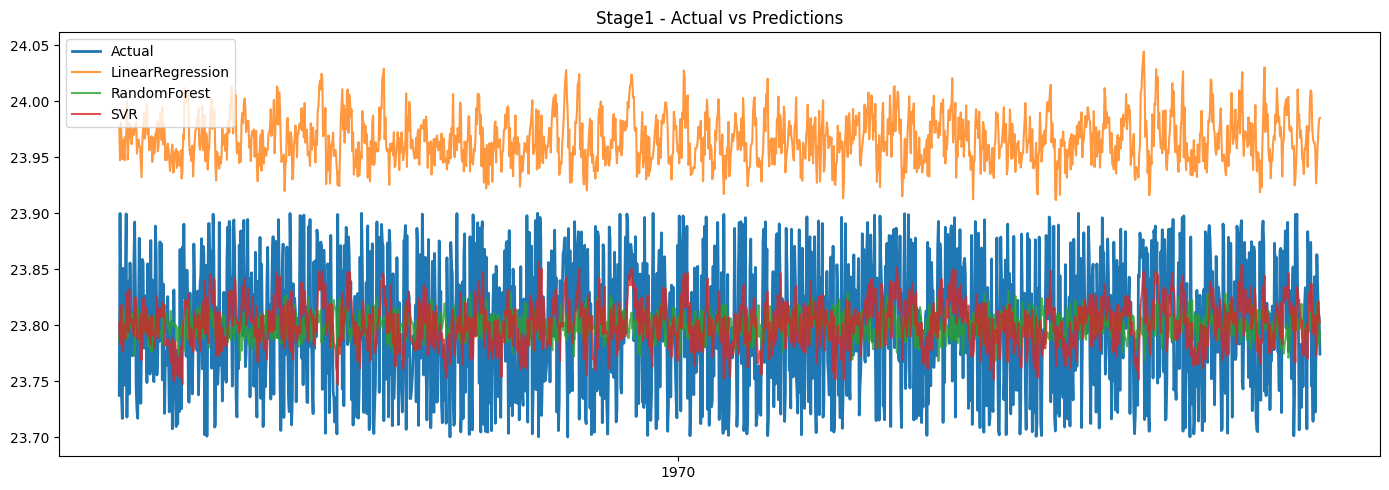

In [57]:
# Cell 14 - Plot Stage1 actual vs predictions (select models)
plt.figure(figsize=(14,5))
plt.plot(preds1.index, preds1['y_true'], label='Actual', linewidth=2)
for name in ['LinearRegression','RandomForest','SVR']:
    if name in preds1.columns:
        plt.plot(preds1.index, preds1[name], label=name, alpha=0.8)
plt.title("Stage1 - Actual vs Predictions")
plt.legend(); plt.tight_layout(); plt.show()

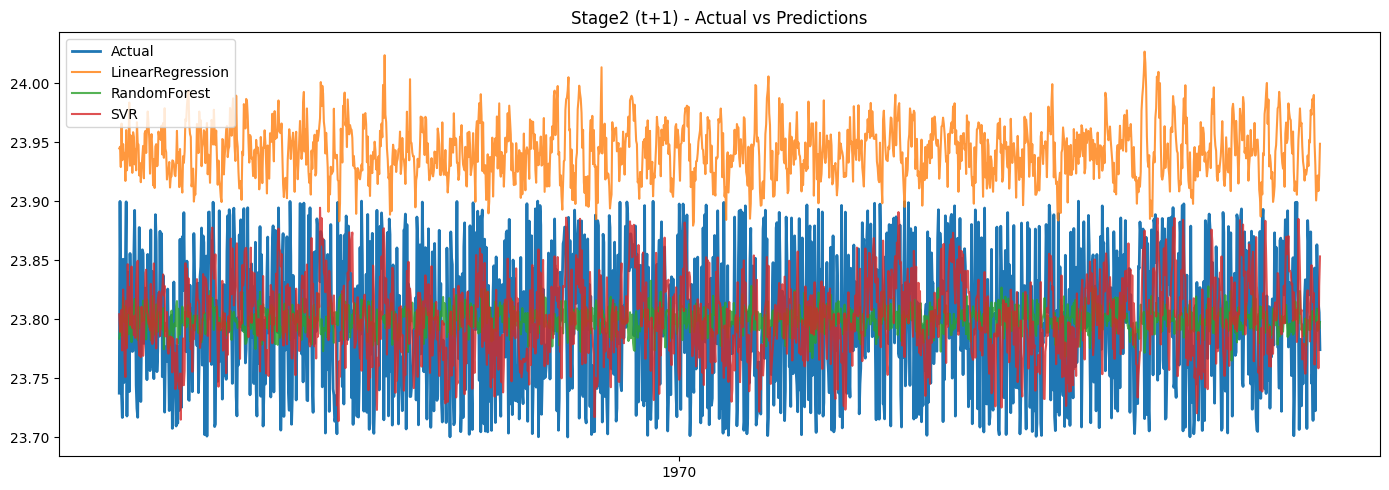

In [58]:
# Cell 15 - Plot Stage2 actual vs predictions (select models)
plt.figure(figsize=(14,5))
plt.plot(preds2.index, preds2['y_true'], label='Actual', linewidth=2)
for name in ['LinearRegression','RandomForest','SVR']:
    if name in preds2.columns:
        plt.plot(preds2.index, preds2[name], label=name, alpha=0.8)
plt.title("Stage2 (t+1) - Actual vs Predictions")
plt.legend(); plt.tight_layout(); plt.show()

Top Stage2 features:
 lag_1           0.174899
roll_mean_3     0.124005
lag_3           0.120465
roll_std_7      0.082574
roll_mean_14    0.078304
lag_14          0.075752
lag_2           0.074886
lag_21          0.064287
roll_std_14     0.060701
roll_mean_7     0.050344
roll_std_3      0.050085
lag_7           0.043697
dow             0.000000
month           0.000000
dtype: float64


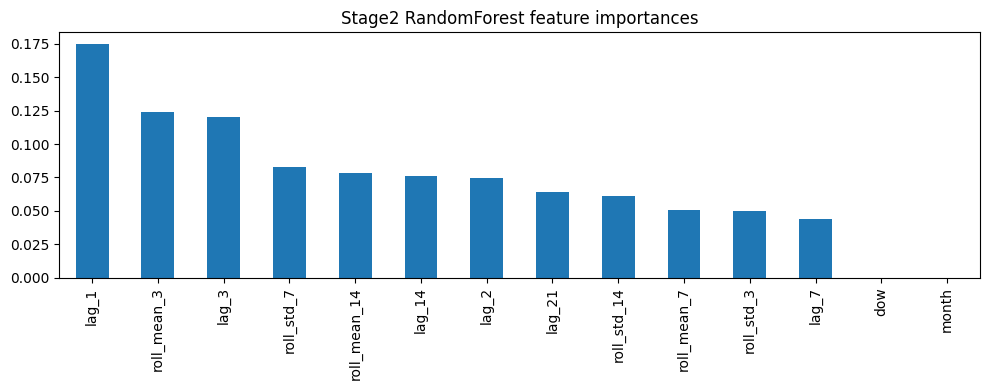

Saved Stage2 feature importances to feature_importances_stage2.csv


In [59]:
# Cell 16 - Feature importance for RandomForest (Stage2 example)
try:
    rf2 = joblib.load(RESULT_DIR / "RandomForest_stage2.joblib")
    rf_model = rf2.named_steps['model']
    if hasattr(rf_model, "feature_importances_"):
        fi = pd.Series(rf_model.feature_importances_, index=X2_train.columns).sort_values(ascending=False)
        print("Top Stage2 features:\n", fi.head(15))
        fi.head(15).plot(kind='bar', figsize=(10,4))
        plt.title("Stage2 RandomForest feature importances")
        plt.tight_layout(); plt.show()
        fi.to_csv(RESULT_DIR / "feature_importances_stage2.csv")
        print("Saved Stage2 feature importances to feature_importances_stage2.csv")
    else:
        print("No feature_importances_ found on RandomForest stage2.")
except Exception as e:
    print("RandomForest stage2 loading failed:", e)

In [60]:
# Cell 17 - Save metadata
meta = {
    'target_column': TARGET,
    'data_path': str(DATA_PATH),
    'result_dir': str(RESULT_DIR),
    'n_rows_stage1': int(len(data_stage1)),
    'n_rows_stage2': int(len(data_stage2)),
    'train_rows_stage1': int(len(X1_train)),
    'test_rows_stage1': int(len(X1_test)),
    'train_rows_stage2': int(len(X2_train)),
    'test_rows_stage2': int(len(X2_test)),
    'models_saved_stage1': [f"{name}_stage1.joblib" for name in models.keys()],
    'models_saved_stage2': [f"{name}_stage2.joblib" for name in models.keys()],
}
pd.Series(meta).to_frame('value').to_csv(RESULT_DIR / 'run_metadata_stage1_stage2.csv')
print("Saved run metadata to run_metadata_stage1_stage2.csv")

Saved run metadata to run_metadata_stage1_stage2.csv
